<a href="https://colab.research.google.com/github/sufiyansayyed19/LLM_Call_Analysis/blob/main/CallAnalysisFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers torch torchaudio accelerate pandas matplotlib wordcloud nltk -q

In [2]:
!wget -P amicorpus/ES2002a/audio https://groups.inf.ed.ac.uk/ami/AMICorpusMirror//amicorpus/ES2002a/audio/ES2002a.Mix-Headset.wav
!wget -P amicorpus/ES2002b/audio https://groups.inf.ed.ac.uk/ami/AMICorpusMirror//amicorpus/ES2002b/audio/ES2002b.Mix-Headset.wav
!wget -P amicorpus/ES2003a/audio https://groups.inf.ed.ac.uk/ami/AMICorpusMirror//amicorpus/ES2003a/audio/ES2003a.Mix-Headset.wav
!wget -P amicorpus/ES2003b/audio https://groups.inf.ed.ac.uk/ami/AMICorpusMirror//amicorpus/ES2003b/audio/ES2003b.Mix-Headset.wav
!wget -P amicorpus/ES2004a/audio https://groups.inf.ed.ac.uk/ami/AMICorpusMirror//amicorpus/ES2004a/audio/ES2004a.Mix-Headset.wav
!wget -P amicorpus/ES2004b/audio https://groups.inf.ed.ac.uk/ami/AMICorpusMirror//amicorpus/ES2004b/audio/ES2004b.Mix-Headset.wav
!wget https://groups.inf.ed.ac.uk/ami/download/temp/../CCBY4.0.txt

--2025-06-29 15:25:56--  https://groups.inf.ed.ac.uk/ami/AMICorpusMirror//amicorpus/ES2002a/audio/ES2002a.Mix-Headset.wav
Resolving groups.inf.ed.ac.uk (groups.inf.ed.ac.uk)... 129.215.202.26
Connecting to groups.inf.ed.ac.uk (groups.inf.ed.ac.uk)|129.215.202.26|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 40724524 (39M) [audio/x-wav]
Saving to: ‘amicorpus/ES2002a/audio/ES2002a.Mix-Headset.wav.1’

ES2002a.Mix-Headset 100%[===================>]  38.84M  10.9MB/s    in 3.6s    

2025-06-29 15:26:01 (10.9 MB/s) - ‘amicorpus/ES2002a/audio/ES2002a.Mix-Headset.wav.1’ saved [40724524/40724524]

--2025-06-29 15:26:01--  https://groups.inf.ed.ac.uk/ami/AMICorpusMirror//amicorpus/ES2002b/audio/ES2002b.Mix-Headset.wav
Resolving groups.inf.ed.ac.uk (groups.inf.ed.ac.uk)... 129.215.202.26
Connecting to groups.inf.ed.ac.uk (groups.inf.ed.ac.uk)|129.215.202.26|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 72952194 (70M) [audio/x-wav]
Saving to:

In [3]:
import glob
import os

# --- CORRECTED FILE FINDING CODE ---
# The wget commands created a simpler folder structure than the script.
# We will search for all .wav files directly within the amicorpus subdirectories.

base_folder = 'amicorpus'
audio_files = glob.glob(os.path.join(base_folder, '**', '*.wav'), recursive=True)

if audio_files:
    print(f"Success! Found {len(audio_files)} audio files.")
    print("Here are the files we will process:")
    for f in audio_files:
        print(f" - {f}")
else:
    print("Error: Could not find any downloaded audio files.")
    print("Please check the 'Files' panel on the left to see the folder structure.")

# Store the list of files in a variable for our main program
AUDIO_FILES_TO_PROCESS = audio_files

Success! Found 6 audio files.
Here are the files we will process:
 - amicorpus/ES2004a/audio/ES2004a.Mix-Headset.wav
 - amicorpus/ES2002b/audio/ES2002b.Mix-Headset.wav
 - amicorpus/ES2003a/audio/ES2003a.Mix-Headset.wav
 - amicorpus/ES2004b/audio/ES2004b.Mix-Headset.wav
 - amicorpus/ES2003b/audio/ES2003b.Mix-Headset.wav
 - amicorpus/ES2002a/audio/ES2002a.Mix-Headset.wav


# STEP 1: IMPORT LIBRARIES & DEFINE CONSTANTS

In [4]:
print("\nSTEP 1: Importing libraries and setting up models...")

# Standard libraries
import json
import warnings
import torch
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from collections import Counter
from nltk import ngrams
import time

# Transformers library for our AI models
from transformers import pipeline, AutoModelForCausalLM, AutoTokenizer

# Suppress harmless warnings
warnings.filterwarnings("ignore")
nltk.download('stopwords', quiet=True)

# --- Configuration ---
TRANSCRIPTION_MODEL = "distil-whisper/distil-large-v2"
LLM_MODEL = "microsoft/Phi-3-mini-4k-instruct"
DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"

print(f"Running on device: {DEVICE}")
if DEVICE == "cpu":
    print("WARNING: GPU not found. The process will be very slow.")


STEP 1: Importing libraries and setting up models...
Running on device: cuda:0


# STEP 2: TRANSCRIPTION

In [5]:
# ==============================================================================
# STEP 2: TRANSCRIPTION (Corrected Version)
# ==============================================================================
print("\nSTEP 2: Transcribing audio files... (This is the most time-consuming step)")
import time # Make sure time is imported
start_time = time.time()

# We load the pipeline with parameters to handle long-form audio
transcriber = pipeline(
    "automatic-speech-recognition",
    model=TRANSCRIPTION_MODEL,
    device=DEVICE,
    chunk_length_s=30,  # Process in 30-second chunks
    stride_length_s=5   # Overlap chunks by 5 seconds
)

transcripts = []
# Let's process a subset first to save time. Change 2 to len(AUDIO_FILES_TO_PROCESS) to run all.
files_to_process = AUDIO_FILES_TO_PROCESS[:2]

print(f"Processing {len(files_to_process)} out of {len(AUDIO_FILES_TO_PROCESS)} files...")

for i, audio_file in enumerate(files_to_process):
    print(f"  ({i+1}/{len(files_to_process)}) Transcribing {audio_file}...")
    # The pipeline now handles long files automatically
    result = transcriber(audio_file)
    transcripts.append({
        "filename": audio_file,
        "transcript": result["text"]
    })

end_time = time.time()
print(f"Transcription complete! Time taken: {end_time - start_time:.2f} seconds.")


STEP 2: Transcribing audio files... (This is the most time-consuming step)


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Processing 2 out of 6 files...
  (1/2) Transcribing amicorpus/ES2004a/audio/ES2004a.Mix-Headset.wav...
  (2/2) Transcribing amicorpus/ES2002b/audio/ES2002b.Mix-Headset.wav...
Transcription complete! Time taken: 201.17 seconds.



STEP 3: Performing Exploratory Data Analysis (EDA)...

--- Basic Transcript Statistics ---
                      File  Word Count  Unique Words
0  ES2004a.Mix-Headset.wav        2151           353
1  ES2002b.Mix-Headset.wav        6113           659


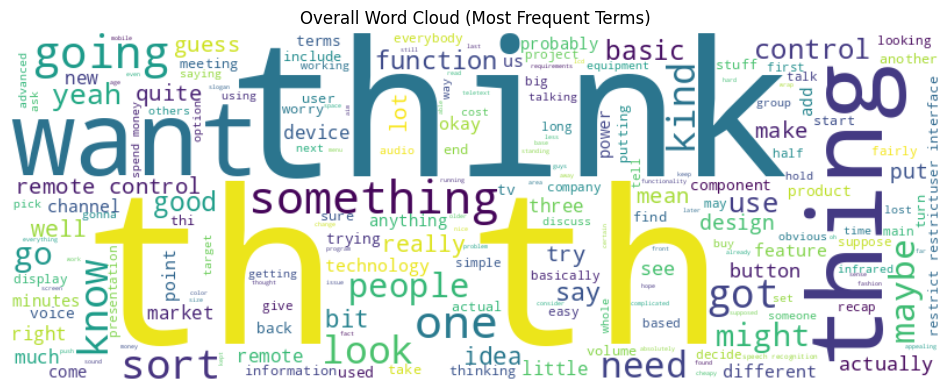

In [6]:
# ==============================================================================
# STEP 3: EXPLORATORY DATA ANALYSIS (EDA)
# ==============================================================================
if transcripts:
    print("\nSTEP 3: Performing Exploratory Data Analysis (EDA)...")

    eda_data = []
    stop_words = set(stopwords.words('english'))
    for item in transcripts:
        text = item["transcript"]
        word_count = len(text.split())
        non_stop_words = [word for word in text.lower().split() if word.isalpha() and word not in stop_words]
        unique_word_count = len(set(non_stop_words))
        eda_data.append({
            "File": item["filename"].split('/')[-1],
            "Word Count": word_count,
            "Unique Words": unique_word_count
        })
    df_eda = pd.DataFrame(eda_data)
    print("\n--- Basic Transcript Statistics ---")
    print(df_eda.to_string())

    full_text = " ".join([item["transcript"] for item in transcripts])
    cleaned_text_for_wc = " ".join([word for word in full_text.lower().split() if word.isalpha() and word not in stop_words])

    if cleaned_text_for_wc:
        wordcloud = WordCloud(width=800, height=300, background_color='white', colormap='viridis').generate(cleaned_text_for_wc)
        plt.figure(figsize=(12, 6))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title('Overall Word Cloud (Most Frequent Terms)')
        plt.show()
else:
    print("No transcripts available to perform EDA.")

In [8]:
# ==============================================================================
# FINAL LLM ANALYSIS CELL (WITH ROBUST AGGREGATION)
# ==============================================================================

if 'transcripts' in locals() and transcripts:
    print("\nSTEP 4: Analyzing transcripts with LLM (Chunking Strategy)...")
    import time, torch, gc, json
    from transformers import AutoModelForCausalLM, AutoTokenizer

    start_time = time.time()

    model = AutoModelForCausalLM.from_pretrained(
        "microsoft/Phi-3-mini-4k-instruct",
        torch_dtype=torch.float16,
        trust_remote_code=True,
        device_map="auto"
    )
    tokenizer = AutoTokenizer.from_pretrained("microsoft/Phi-3-mini-4k-instruct")

    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token

    final_results = []
    for i, item in enumerate(transcripts):
        print(f"\n  ({i+1}/{len(transcripts)}) Analyzing transcript for {item['filename']}...")

        full_transcript_text = item['transcript']

        words = full_transcript_text.split()
        chunk_size = 400
        overlap = 50
        chunks = [" ".join(words[j:j + chunk_size]) for j in range(0, len(words), chunk_size - overlap)]

        print(f"    Split transcript into {len(chunks)} chunks.")

        chunk_analyses = []
        for k, chunk in enumerate(chunks):
            print(f"      Analyzing chunk {k+1}/{len(chunks)}...", end="")

            messages = [{"role": "user", "content": f"""
Analyze the text chunk from a meeting and respond with a JSON object with keys "summary", "action_items", and "key_topics".

Text Chunk:
---
{chunk}
---

Provide ONLY the JSON object.
"""}]
            prompt = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)

            try:
                inputs = tokenizer(prompt, return_tensors="pt", truncation=True)
                inputs = {key: val.to("cuda") for key, val in inputs.items()}

                with torch.no_grad():
                    outputs = model.generate(**inputs, max_new_tokens=512, do_sample=False, pad_token_id=tokenizer.pad_token_id)

                response_ids = outputs[0][inputs['input_ids'].shape[1]:]
                generated_text = tokenizer.decode(response_ids, skip_special_tokens=True).strip()

                start_idx = generated_text.find('{')
                end_idx = generated_text.rfind('}') + 1
                if start_idx != -1 and end_idx > start_idx:
                    json_text = generated_text[start_idx:end_idx]
                    chunk_analyses.append(json.loads(json_text))
                    print(" Done.")
                else:
                    print(" No JSON found.")
            except Exception as e:
                print(f" ERROR on chunk: {e}")

        # --- THIS IS THE CORRECTED AGGREGATION LOGIC ---
        if chunk_analyses:
            aggregated_summary = " ".join([res.get('summary', '') for res in chunk_analyses])

            unique_actions = set()
            for res in chunk_analyses:
                for action_item in res.get('action_items', []):
                    if isinstance(action_item, dict):
                        # If item is a dict, join its values into a string
                        unique_actions.add(" ".join(str(v) for v in action_item.values()))
                    else:
                        # Otherwise, assume it's a string or other hashable type
                        unique_actions.add(str(action_item))

            unique_topics = set()
            for res in chunk_analyses:
                for topic_item in res.get('key_topics', []):
                    if isinstance(topic_item, dict):
                        unique_topics.add(" ".join(str(v) for v in topic_item.values()))
                    else:
                        unique_topics.add(str(topic_item))

            final_analysis = {
                "summary": aggregated_summary,
                "action_items": list(unique_actions),
                "key_topics": list(unique_topics)
            }
            final_results.append({"filename": item['filename'], "analysis": final_analysis})
            print(f"    --> Successfully aggregated analysis for {item['filename']}")
        else:
            print(f"    --> No chunks were successfully analyzed for {item['filename']}")

    end_time = time.time()
    print(f"\nLLM analysis complete! Time taken: {end_time - start_time:.2f} seconds.")

    analysis_results = final_results

    del model, tokenizer
    torch.cuda.empty_cache()
    gc.collect()

else:
    print("No transcripts available to analyze.")


STEP 4: Analyzing transcripts with LLM (Chunking Strategy)...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.



  (1/2) Analyzing transcript for amicorpus/ES2004a/audio/ES2004a.Mix-Headset.wav...
    Split transcript into 7 chunks.
      Analyzing chunk 1/7... Done.
      Analyzing chunk 2/7... Done.
      Analyzing chunk 3/7... Done.
      Analyzing chunk 4/7... Done.
      Analyzing chunk 5/7... Done.
      Analyzing chunk 6/7... Done.
      Analyzing chunk 7/7... Done.
    --> Successfully aggregated analysis for amicorpus/ES2004a/audio/ES2004a.Mix-Headset.wav

  (2/2) Analyzing transcript for amicorpus/ES2002b/audio/ES2002b.Mix-Headset.wav...
    Split transcript into 18 chunks.
      Analyzing chunk 1/18... Done.
      Analyzing chunk 2/18... Done.
      Analyzing chunk 3/18... Done.
      Analyzing chunk 4/18... Done.
      Analyzing chunk 5/18... Done.
      Analyzing chunk 6/18... Done.
      Analyzing chunk 7/18... Done.
      Analyzing chunk 8/18... Done.
      Analyzing chunk 9/18... Done.
      Analyzing chunk 10/18... Done.
      Analyzing chunk 11/18... Done.
      Analyzing chunk

In [9]:
# ==============================================================================
# STEP 5: FINAL REPORT
# ==============================================================================
if 'analysis_results' in locals() and analysis_results:
    print("\n\n" + "="*30 + "\n  FINAL ANALYSIS REPORT\n" + "="*30 + "\n")
    for result in analysis_results:
        print(f"--- Analysis for: {result['filename']} ---")
        analysis = result['analysis']

        print("\n[+] Summary:")
        print(analysis.get('summary', 'N/A'))

        print("\n[+] Action Items:")
        action_items = analysis.get('action_items', [])
        if action_items:
            for point in action_items: print(f"  - {point}")
        else: print("  None identified.")

        print("\n[+] Key Topics:")
        key_topics = analysis.get('key_topics', [])
        if key_topics:
            for step in key_topics: print(f"  - {step}")
        else: print("  None identified.")
        print("\n" + "-"*50 + "\n")
else:
    print("\nNo analysis results to display.")

print("End of program.")



  FINAL ANALYSIS REPORT

--- Analysis for: amicorpus/ES2004a/audio/ES2004a.Mix-Headset.wav ---

[+] Summary:
The meeting is the first for the team, led by Sarah, the project manager. The team will get to know each other, undergo tool training, discuss the project plan, and brainstorm ideas. They have 25 minutes for this agenda. The team is developing a remote control that should be original, user-friendly, and appealing to a wide range of users, including grannies and kids, and possibly even pets. The functional design, conceptual design, and detailed design are the next steps in the project. The text appears to be a transcript from a meeting where the speaker discusses the unique features of dogs, acknowledges the quality of a drawing, and attempts to describe various animals, including a crocodile, a T-Rex, a pelican, and an eagle, while also making light-hearted comments about golf skills. The meeting discussed the characteristics of a product, its pricing, and market strategy. Th